In [1]:
import random
import time
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Start Spark
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

json_output_path = "../../output/10Ksift_data.json" # 100M_bigann_base.json is too large and to be included
df = spark.read.json(json_output_path)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/07 11:59:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# ----- Configuration Variables -----

sample_size = 10000  # Number of samples to extract from the JSON file
K = 100  # Number of clusters for clustering algorithm
max_iterations = 10 # Max number of iterations when running K-means

# Distance metric for calculations
distance_metric = 2

# Available distance metrics:
# 1  -> Manhattan distance
# 2  -> Euclidean distance
# np.inf -> Chebyshev distance

In [4]:
# Get sample_size of rows
df_sample = df.limit(sample_size)

In [5]:
# Load the data
data_rdd = df_sample.select("vector").rdd.map(lambda row: row[0])

In [6]:

# Initialise K centroides randomly
centroids = data_rdd.takeSample(False, K)

print("Centroïdes initiated:", centroids)

Centroïdes initiated: [[-115, -94, -105, -98, -110, -118, -126, -128, -118, -101, -40, -62, -126, -128, -128, -127, -2, -96, -88, -122, -127, -127, -128, -67, -2, -116, -125, -127, -128, -128, -128, -48, -116, -125, -124, -116, -76, -40, -98, -107, -62, -118, -118, -84, -85, -81, -118, -117, -2, -88, -120, -127, -128, -128, -126, -9, -2, -63, -117, -128, -128, -128, -128, -102, -105, -115, -116, -105, -44, -86, -105, -114, -96, -126, -128, -127, -95, -68, -2, -93, -2, -37, -116, -128, -128, -125, -54, -82, -39, -5, -111, -128, -128, -128, -127, -125, -76, -41, -113, -126, -125, -115, -107, -118, -107, -114, -127, -128, -125, -86, -46, -106, -116, -107, -94, -123, -116, -111, -88, -113, -71, -58, -109, -128, -128, -128, -127, -125], [-91, -82, -124, -119, -42, -86, -125, -128, 10, -56, -128, -127, -122, -120, -126, -121, -111, -126, -126, -115, -55, -82, -126, -125, -128, -128, -116, -104, -88, -120, -128, -128, -78, -107, -126, -90, 10, -122, -128, -125, 10, -69, -128, -120, -108, -127

In [7]:
def closest_centroid(point, centroids):
    """Returns the index of the nearest centroid."""
    distances = [np.linalg.norm(np.array(point) - np.array(c), ord=distance_metric) for c in centroids]
    return np.argmin(distances), point

In [8]:
def compute_new_centroids(clustered_rdd, K):
    """Computes the new centroids by averaging the points assigned to each cluster."""
    cluster_groups = clustered_rdd.map(lambda x: (x[0], (np.array(x[1]), 1)))  # (cluster, (point, 1))
    
    # Sum of points and count of elements per cluster
    cluster_sums = cluster_groups.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    
    # Average of points (new centroids)
    new_centroids = cluster_sums.map(lambda x: x[1][0] / x[1][1]).collect()
    
    return new_centroids

In [9]:
loss_values = []  # Store the loss at each iteration

total_start_time = time.time()  # Start overall timer

for i in range(max_iterations):
    iteration_start_time = time.time()  # Start iteration timer
    
    clustered_rdd = data_rdd.map(lambda point: closest_centroid(point, centroids))
    
    loss = clustered_rdd.map(lambda x: np.linalg.norm(np.array(x[1]) - np.array(centroids[x[0]]), ord=distance_metric) ** 2).sum()
    loss_values.append(loss)
    
    centroids = compute_new_centroids(clustered_rdd, K)
    
    iteration_time = time.time() - iteration_start_time  # Execution time for the iteration
    
    print(f"Iteration {i+1}: Loss = {loss:.4f}, Time = {iteration_time:.2f}s")

total_time = time.time() - total_start_time  # Compute total execution time

print(f"K-Means Completed! Total Time: {total_time:.2f}s")

Iteration 1: Loss = 1320009843.0000, Time = 26.13s


Iteration 2: Loss = 873739433.7248, Time = 16.29s


Iteration 3: Loss = 846849731.0732, Time = 10.58s


Iteration 4: Loss = 837239120.3426, Time = 11.86s


Iteration 5: Loss = 832288740.2350, Time = 18.51s


Iteration 6: Loss = 828953085.9729, Time = 16.23s


Iteration 7: Loss = 826570652.6058, Time = 16.51s


Iteration 8: Loss = 824743373.3076, Time = 16.40s


Iteration 9: Loss = 823509107.1851, Time = 16.25s


Iteration 10: Loss = 822514918.7008, Time = 16.24s
K-Means Completed! Total Time: 164.99s


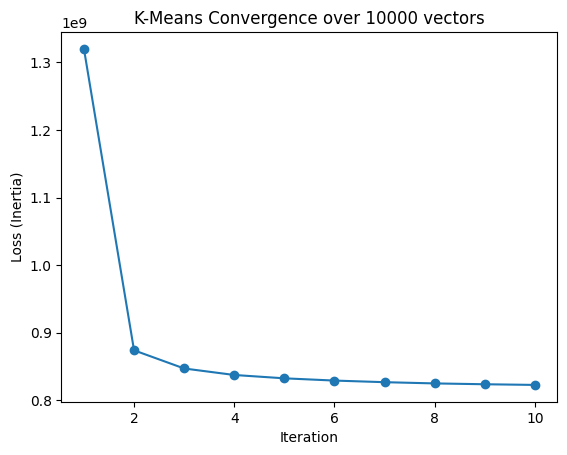

In [10]:
plt.plot(range(1, max_iterations + 1), loss_values, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Loss (Inertia)")
plt.title("K-Means Convergence over " + str(sample_size) + " vectors")
plt.show()